# Adding interactive filters to plots

## Introduction

This guide will show you how to build interactive timeseries plots using advanced visualization libraries like Plotly, Bokeh, and Altair. We'll focus on these two components:&#x20;

1. **Dropdown menus** let you toggle between different series in the same plot
2. **Date range sliders** allowing you to observe trends between specific periods

## Dropdown menu

A dropdown menu is really handy if you have a lot of categories in the data, e.g. stocks or countries, and you want to observe the trends using a line plot in the same plot or figure. This saves you from creating several plots in a loop.

In this tutorial, we'll use a [Covid 19 dataset](https://www.kaggle.com/imdevskp/corona-virus-report) which shows the covid caseload across different countries and add a dropdown to change the country within the same plot.

### Altair

You can read more about interactive components with Altair [here](https://altair-viz.github.io/gallery/multiple\_interactions.html). Creating the plot with Altair involves binding a country list to a selection component:&#x20;

In [1]:
import pandas as pd
import datapane as dp
import altair as alt

alt.data_transformers.disable_max_rows()

df = pd.read_csv("./covid_19_clean_complete.csv")
df["Date"] = pd.to_datetime(df["Date"])
country_list = list(df["Country/Region"].unique())

input_dropdown = alt.binding_select(options=country_list)
selection = alt.selection_single(
    fields=["Country/Region"], bind=input_dropdown, name="Country"
)

alt_plot = (
    alt.Chart(df)
    .mark_line()
    .encode(x="Date", y="Confirmed", tooltip="Confirmed")
    .add_selection(selection)
    .transform_filter(selection)
)

report = dp.Report(dp.Plot(alt_plot))
report.save(path="interactive-altair-plot.html")

Report saved to ./interactive-altair-plot.html

Running that code gives us:

In [2]:
from dpdocsutils import previews
previews.embed_local_report('/guides/adding-interactive-filters-to-plots/interactive-altair-plot.html', width="100%", height=480)

### Plotly

Plotly offers a range of interactive options which are called [Custom Controls](https://plotly.com/python/#controls). The best part about these controls is that they can be added to the plots purely in pythonic code. Let's visualize the same plot in Plotly:&#x20;

In [3]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

df = pd.read_csv("./covid_19_clean_complete.csv")
fig = go.Figure()
country_list = list(df["Country/Region"].unique())

for country in country_list:
    fig.add_trace(
        go.Scatter(
            x=df["Date"][df["Country/Region"] == country],
            y=df["Confirmed"][df["Country/Region"] == country],
            name=country,
            visible=True,
        )
    )

buttons = []

for i, country in enumerate(country_list):
    args = [False] * len(country_list)
    args[i] = True
    button = dict(label=country, method="update", args=[{"visible": args}])
    buttons.append(button)

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            type="dropdown",
            buttons=buttons,
            x=0,
            y=1.1,
            xanchor="left",
            yanchor="bottom",
        )
    ],
    autosize=False,
    width=1000,
    height=800,
)

report = dp.Report(dp.Plot(fig))
report.save(path="interactive-plotly-plot.html")

Report saved to ./interactive-plotly-plot.html

And you will have a nice-looking dropdown added to the time-series plot:&#x20;

In [4]:
from dpdocsutils import previews
previews.embed_local_report('/guides/adding-interactive-filters-to-plots/interactive-plotly-plot.html', width="100%", height=920)

### Bokeh

Bokeh has components called widgets which can be used to add several interactive components to your plots. Widgets are primarily aimed at creating dashboard components hosted on the Bokeh server. You can read more about widgets [here](https://docs.bokeh.org/en/latest/docs/user\_guide/interaction/widgets.html).

Keep in mind that in order to create widgets for standalone HTML files or even while working with Jupyter notebook, you will need to use **CustomJS** callbacks. This requires a bit of JavaScript knowledge to get the dropdown working properly. If you want to do it the pure pythonic way, you have to use the Bokeh server to make the widgets work.

We will replicate the same use-case as above using Bokeh dropdowns.

In [5]:
import pandas as pd
import datapane as dp
from bokeh.io import output_file, show, output_notebook, save
from bokeh.models import ColumnDataSource, Select, DateRangeSlider
from bokeh.plotting import figure, show
from bokeh.models import CustomJS
from bokeh.layouts import row, column

df = pd.read_csv("./covid_19_clean_complete.csv")
country_list = list(df["Country/Region"].unique())
df["Date"] = pd.to_datetime(df["Date"])

cols1 = df[["Country/Region", "Date", "Confirmed"]]
cols2 = cols1[cols1["Country/Region"] == "Afghanistan"]

Overall = ColumnDataSource(data=cols1)
Curr = ColumnDataSource(data=cols2)

# plot and the menu is linked with each other by this callback function
callback = CustomJS(
    args=dict(source=Overall, sc=Curr),
    code="""
        var f = cb_obj.value
        sc.data['Date']=[]
        sc.data['Confirmed']=[]
        for(var i = 0; i <= source.get_length(); i++){
            if (source.data['Country/Region'][i] == f){
                sc.data['Date'].push(source.data['Date'][i])
                sc.data['Confirmed'].push(source.data['Confirmed'][i])
             }
        }   

        sc.change.emit();
""",
)

menu = Select(
    options=country_list, value="Afghanistan", title="Country"
)  # drop down menu

bokeh_p = figure(
    x_axis_label="Date",
    y_axis_label="Confirmed",
    y_axis_type="linear",
    x_axis_type="datetime",
)  # creating figure object
bokeh_p.line(
    x="Date", y="Confirmed", color="green", source=Curr
)  # plotting the data using glyph circle

menu.js_on_change("value", callback)  # calling the function on change of selection
layout = column(menu, bokeh_p)  # creating the layout

report = dp.Report(dp.Plot(layout))
report.save(path="interactive-bokeh-plot.html")

Report saved to ./interactive-bokeh-plot.html

This is how the plot will look:&#x20;

In [6]:
from dpdocsutils import previews
previews.embed_local_report('/guides/adding-interactive-filters-to-plots/interactive-bokeh-plot.html', width="100%", height=800)

### Matplotlib/Seaborn

If you want to use a non-interactive library like Matplotlib or Seaborn, you can use the `dp.Select`  block to mimic the interactive filter ability, like this:&#x20;

Report saved to ./interactive-matplotlib-plot.html

<Figure size 3000x1500 with 0 Axes>

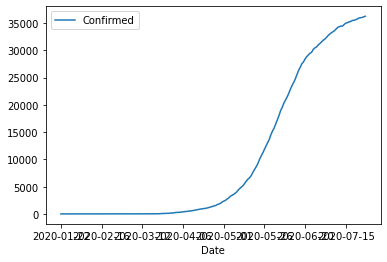

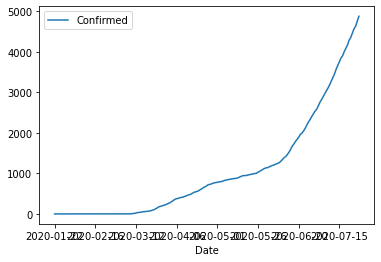

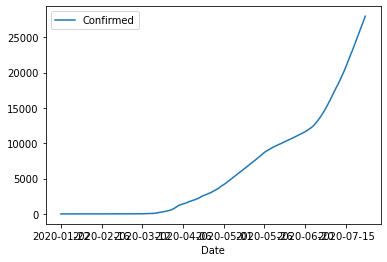

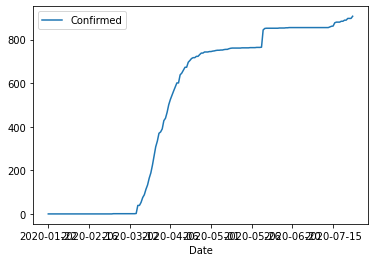

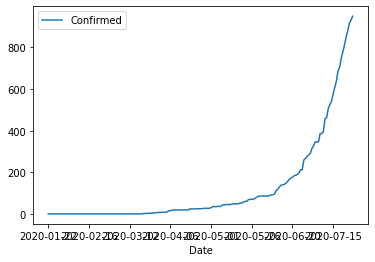

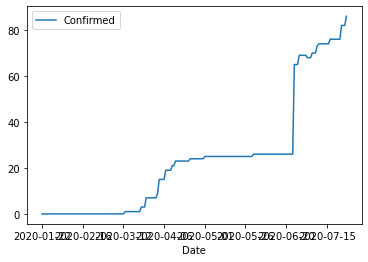

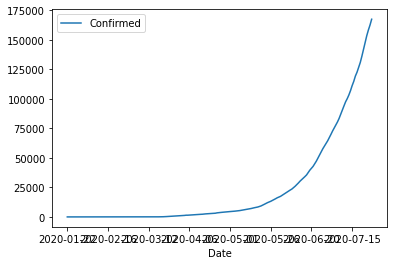

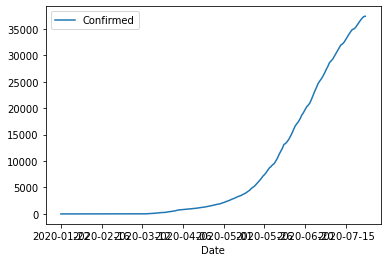

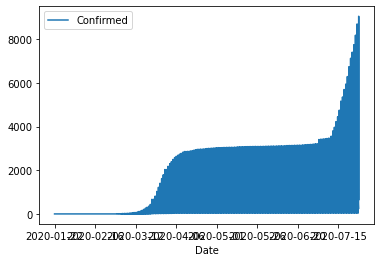

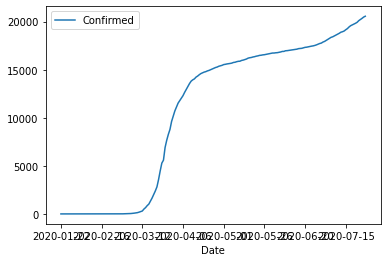

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import datapane as dp

df = pd.read_csv("./covid_19_clean_complete.csv")
country_list = list(df["Country/Region"].unique())[:10]

plt.figure(figsize=(10, 5), dpi=300)

plot_list = [
    dp.Plot(
        df[df["Country/Region"] == country].plot.line(x="Date", y="Confirmed"),
        label=country,
    )
    for country in country_list
]

report = dp.Report(dp.Select(blocks=plot_list))
report.save(path="interactive-matplotlib-plot.html")

In this example, we've restricted it to 10 plots.&#x20;

In [8]:
from dpdocsutils import previews
previews.embed_local_report('/guides/adding-interactive-filters-to-plots/interactive-matplotlib-plot.html', width="100%", height=700)

## Date range slider

Another interactive component that comes really handy (especially while working with timeseries plots) is a date range slider.

Since most of the timeseries plots have a date range in the X-axis, a slider allows you to dynamically change the period and view only a section of the plot to understand the trends for that particular period.

### Altair

With Altair, similar to Plotly, you can use the generic slider to use as a Date Range Slider. However, keep in mind that Vega considers the timeseries data in milliseconds and it is  difficult to show the date information in the slider. It works if you have yearly data - but if the data is broken into days and months, it is tricky to make it work.

In [9]:
import altair as alt
import pandas as pd

alt.data_transformers.disable_max_rows()

df = pd.read_csv("./covid_19_clean_complete.csv")
df["Date"] = pd.to_datetime(df["Date"])
country_list = list(df["Country/Region"].unique())

input_dropdown = alt.binding_select(options=country_list)
selection = alt.selection_single(
    fields=["Country/Region"], bind=input_dropdown, name="Country"
)


def timestamp(t):
    return pd.to_datetime(t).timestamp() * 1000


slider = alt.binding_range(
    step=30 * 24 * 60 * 60 * 1000,  # 30 days in milliseconds
    min=timestamp(min(df["Date"])),
    max=timestamp(max(df["Date"])),
)

select_date = alt.selection_single(
    fields=["Date"],
    bind=slider,
    init={"Date": timestamp(min(df["Date"]))},
    name="slider",
)

alt_plot = (
    alt.Chart(df)
    .mark_line()
    .encode(x="Date", y="Confirmed", tooltip="Confirmed")
    .add_selection(selection)
    .transform_filter(selection)
    .add_selection(select_date)
    .transform_filter(
        "(year(datum.Date) == year(slider.Date[0])) && "
        "(month(datum.Date) == month(slider.Date[0]))"
    )
)

report = dp.Report(dp.Plot(alt_plot))
report.save(path="interactive-slider-altair-plot.html")

Report saved to ./interactive-slider-altair-plot.html

How is your experience of Datapane? Please take two minutes to answer our anonymous product survey <a href='https://bit.ly/3lWjRlr' target='_blank'>here</a>

This is how it will look:&#x20;

In [10]:
from dpdocsutils import previews
previews.embed_local_report('/guides/adding-interactive-filters-to-plots/interactive-slider-altair-plot.html', width="100%", height=600)

### Plotly

Plotly has a generic slider component that can be used to change the data corresponding to any axis. While it does not have a specific slider for timeseries data, the generic slider can be used to create a date range slider. You can read more about sliders [here](https://plotly.com/python/sliders/).

To create a slider, we will take the same timeseries plot created previously with the dropdown menu and add a slider component below the plot - just a single extra parameter `xaxis1_rangeslider_visible`!&#x20;

In [11]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

df = pd.read_csv("./covid_19_clean_complete.csv")

fig = go.Figure()

country_list = list(df["Country/Region"].unique())

for country in country_list:
    fig.add_trace(
        go.Scatter(
            x=df["Date"][df["Country/Region"] == country],
            y=df["Confirmed"][df["Country/Region"] == country],
            name=country,
            visible=True,
        )
    )

buttons = []

for i, country in enumerate(country_list):
    args = [False] * len(country_list)
    args[i] = True

    # create a button object for the country we are on
    button = dict(label=country, method="update", args=[{"visible": args}])

    # add the button to our list of buttons
    buttons.append(button)

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            type="dropdown",
            buttons=buttons,
            x=0,
            y=1.1,
            xanchor="left",
            yanchor="bottom",
        )
    ],
    autosize=False,
    width=1000,
    height=800,
    xaxis1_rangeslider_visible=True,
)

report = dp.Report(dp.Plot(fig))
report.save(path="interactive-slider-plotly-plot.html")

Report saved to ./interactive-slider-plotly-plot.html

This will give you something like this:&#x20;

In [12]:
from dpdocsutils import previews
previews.embed_local_report('/guides/adding-interactive-filters-to-plots/interactive-slider-plotly-plot.html', width="100%", height=900)

### Bokeh

Similar to the Dropdown widget, Bokeh has a Date Range Slider widget specifically to work with timeseries data. This widget is different from the generic Range Slider widget. In order to make this widget work, a CustomJS callback is required.

In [13]:
import pandas as pd
import datapane as dp
from bokeh.io import output_file, show, output_notebook, save
from bokeh.models import ColumnDataSource, Select, DateRangeSlider
from bokeh.plotting import figure, show
from bokeh.models import CustomJS
from bokeh.layouts import row, column

df = pd.read_csv("./covid_19_clean_complete.csv")
country_list = list(df["Country/Region"].unique())
df["Date"] = pd.to_datetime(df["Date"])

cols1 = df.loc[:, ["Country/Region", "Date", "Confirmed"]]
cols2 = cols1[cols1["Country/Region"] == "Afghanistan"]

Overall = ColumnDataSource(data=cols1)
Curr = ColumnDataSource(
    data=cols2
)  # plot and the menu is linked with each other by this callback function

callback = CustomJS(
    args=dict(source=Overall, sc=Curr),
    code="""
        var f = cb_obj.value
        sc.data['Date']=[]
        sc.data['Confirmed']=[]
        for(var i = 0; i <= source.get_length(); i++){
            if (source.data['Country/Region'][i] == f){
                sc.data['Date'].push(source.data['Date'][i])
                sc.data['Confirmed'].push(source.data['Confirmed'][i])
             }
        }   

        sc.change.emit();
		""",
)

menu = Select(
    options=country_list, value="Afghanistan", title="Country/Region"
)  # drop down menu
bokeh_p = figure(
    x_axis_label="Date",
    y_axis_label="Confirmed",
    y_axis_type="linear",
    x_axis_type="datetime",
)  # creating figure object
bokeh_p.line(
    x="Date", y="Confirmed", color="green", source=Curr
)  # plotting the data using glyph circle

menu.js_on_change("value", callback)  # calling the function on change of selection

date_range_slider = DateRangeSlider(
    value=(min(df["Date"]), max(df["Date"])), start=min(df["Date"]), end=max(df["Date"])
)

date_range_slider.js_link("value", bokeh_p.x_range, "start", attr_selector=0)
date_range_slider.js_link("value", bokeh_p.x_range, "end", attr_selector=1)
layout = column(menu, date_range_slider, bokeh_p)

report = dp.Report(dp.Plot(layout))
report.save(path="interactive-slider-bokeh-plot.html")

Report saved to ./interactive-slider-bokeh-plot.html

This is how it will look like:&#x20;

In [14]:
from dpdocsutils import previews
previews.embed_local_report('/guides/adding-interactive-filters-to-plots/interactive-slider-bokeh-plot.html', width="100%", height=800)